<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/09_pytorch_model_deployment_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 09. PyTorch Model Deployment Exercises

Welcome to the 09. PyTorch Model Deployment exercises.

Your objective is to write code to satisify each of the exercises below.

Some starter code has been provided to make sure you have all the resources you need.

> **Note:** There may be more than one solution to each of the exercises.

## Resources

1. These exercises/solutions are based on [section 09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/jOX5ZCkWO-0) (but try the exercises yourself first!).
3. See [all solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

> **Note:** The first section of this notebook is dedicated to getting various helper functions and datasets used for the exercises. The exercises start at the heading "Exercise 1: ...".

### Get various imports and helper functions

The code in the following cells prepares imports and data for the exercises below. They are taken from [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/). 

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) > 1, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    # !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")


torch version: 2.9.1+cu128
torchvision version: 0.24.1+cu128


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    # !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Get data

Want to download the data we've been using in PyTorch Model Deployment: https://www.learnpytorch.io/09_pytorch_model_deployment/#1-getting-data

In [16]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                           destination="pizza_steak_sushi_20_percent")
image_path

[INFO] data/pizza_steak_sushi_20_percent directory exists, skipping download.


PosixPath('data/pizza_steak_sushi_20_percent')

In [17]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

### Preprocess data

Turn images into tensors using same code as PyTorch Paper Replicating section 2.1 and 2.2: https://www.learnpytorch.io/08_pytorch_paper_replicating/#21-prepare-transforms-for-images

In [18]:
# Create image size (from Table 3 in the ViT paper) 
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])           
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [19]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x77df74081f60>,
 ['pizza', 'steak', 'sushi'])

In [20]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

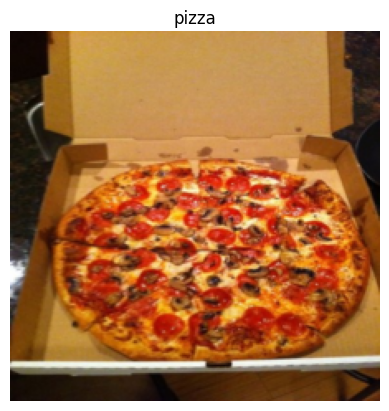

In [21]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

## Exercise 1. Make and time predictions with both feature extractor models on the test dataset using the GPU (`device="cuda"`). 

* Compare the model's prediction times on GPU vs CPU - does this close the gap between them? As in, does making predictions on the GPU make the ViT feature extractor prediction times closer to the EffNetB2 feature extractor prediction times?
* You'll find code to do these steps in [section 5. Making predictions with our trained models and timing them](https://www.learnpytorch.io/09_pytorch_model_deployment/#5-making-predictions-with-our-trained-models-and-timing-them) and [section 6. Comparing model results, prediction times and size](https://www.learnpytorch.io/09_pytorch_model_deployment/#6-comparing-model-results-prediction-times-and-size).

EffNetB2

In [34]:
def create_effnetb2(num_classes:int=3,
                    seed:int=42,
                    device:str="cuda"):
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # freeze params
    for param in model.parameters():
        param.requires_grad = False

    torch.manual_seed(42)

    # create classifier
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features=1408,
                  out_features=num_classes)
    )

    return model.to(device), transforms


In [35]:
EffNetB2, EffNetB2_transforms = create_effnetb2()
# create loss fn and optim
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(EffNetB2.parameters(),lr=0.001)

In [37]:
# prepare dataloader
BATCH_SIZE = 32
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=EffNetB2_transforms,
                                                                                                 batch_size=BATCH_SIZE)

len(train_dataloader_effnetb2), len(test_dataloader_effnetb2), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

In [38]:
# train and time
from timeit import default_timer as timer
start_time = timer()
set_seeds()
EffNetB2_results = engine.train(model=EffNetB2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device,
                                epochs=10)
end_time = timer()

print(f"total time: {- start_time + end_time:.3f}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9611 | train_acc: 0.6062 | test_loss: 0.7226 | test_acc: 0.9472
Epoch: 2 | train_loss: 0.7017 | train_acc: 0.8562 | test_loss: 0.5695 | test_acc: 0.9534
Epoch: 3 | train_loss: 0.5663 | train_acc: 0.8625 | test_loss: 0.4730 | test_acc: 0.9625
Epoch: 4 | train_loss: 0.4289 | train_acc: 0.9250 | test_loss: 0.4161 | test_acc: 0.9500
Epoch: 5 | train_loss: 0.4153 | train_acc: 0.9083 | test_loss: 0.3751 | test_acc: 0.9506
Epoch: 6 | train_loss: 0.4056 | train_acc: 0.9000 | test_loss: 0.3380 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.4054 | train_acc: 0.8771 | test_loss: 0.3128 | test_acc: 0.9625
Epoch: 8 | train_loss: 0.3764 | train_acc: 0.9042 | test_loss: 0.3294 | test_acc: 0.9381
Epoch: 9 | train_loss: 0.3667 | train_acc: 0.9021 | test_loss: 0.3000 | test_acc: 0.9193
Epoch: 10 | train_loss: 0.3454 | train_acc: 0.8562 | test_loss: 0.2708 | test_acc: 0.9625
total time: 50.475


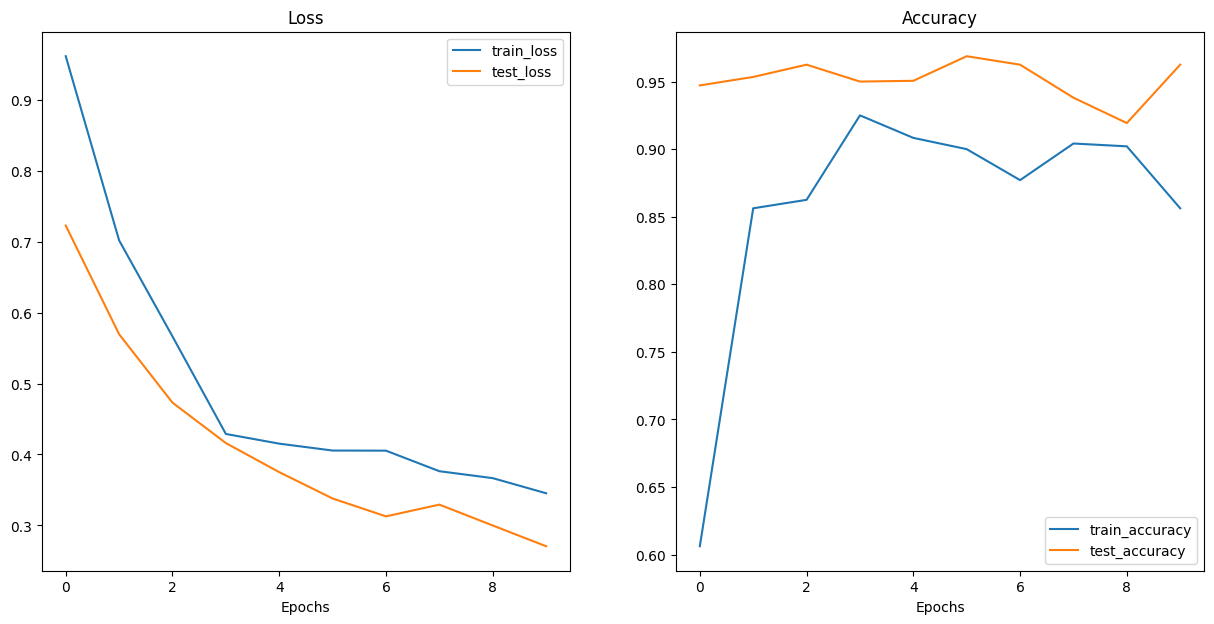

In [39]:
plot_loss_curves(EffNetB2_results)

## Exercise 2. The ViT feature extractor seems to have more learning capacity (due to more parameters) than EffNetB2, how does it go on the larger 20% split of the entire Food101 dataset?

* Train a ViT feature extractor on the 20% Food101 dataset for 5 epochs, just like we did with EffNetB2 in section [10. Creating FoodVision Big](https://www.learnpytorch.io/09_pytorch_model_deployment/#10-creating-foodvision-big).

In [41]:
def create_vit(num_classes:int=3,
                    seed:int=42,
                    device:str="cuda"):
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    # freeze params
    for param in model.parameters():
        param.requires_grad = False

    torch.manual_seed(42)

    # create classifier
    model.heads = nn.Sequential(
        nn.Linear(in_features=768,
                  out_features=num_classes)
    )

    return model.to(device), transforms

In [42]:
vit, vit_transforms = create_vit()

vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [43]:
BATCH_SIZE = 32

train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transforms,
                                                                                       batch_size=BATCH_SIZE)

len(train_dataloader_vit), len(test_dataloader_vit), len(class_names)

(15, 5, 3)

In [45]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vit.parameters(),lr=0.001)
# train and time
from timeit import default_timer as timer
start_time = timer()
set_seeds()
vit_results = engine.train(model=vit,
                                train_dataloader=train_dataloader_vit,
                                test_dataloader=test_dataloader_vit,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device,
                                epochs=10)
end_time = timer()

print(f"total time: {- start_time + end_time:.3f}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381
Epoch: 2 | train_loss: 0.2532 | train_acc: 0.9062 | test_loss: 0.1672 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9542 | test_loss: 0.1273 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1276 | train_acc: 0.9625 | test_loss: 0.1074 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1159 | train_acc: 0.9646 | test_loss: 0.0953 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1273 | train_acc: 0.9375 | test_loss: 0.0832 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0897 | train_acc: 0.9771 | test_loss: 0.0845 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0919 | train_acc: 0.9812 | test_loss: 0.0764 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0922 | train_acc: 0.9792 | test_loss: 0.0734 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0658 | train_acc: 0.9833 | test_loss: 0.0644 | test_acc: 0.9847
total time: 84.052


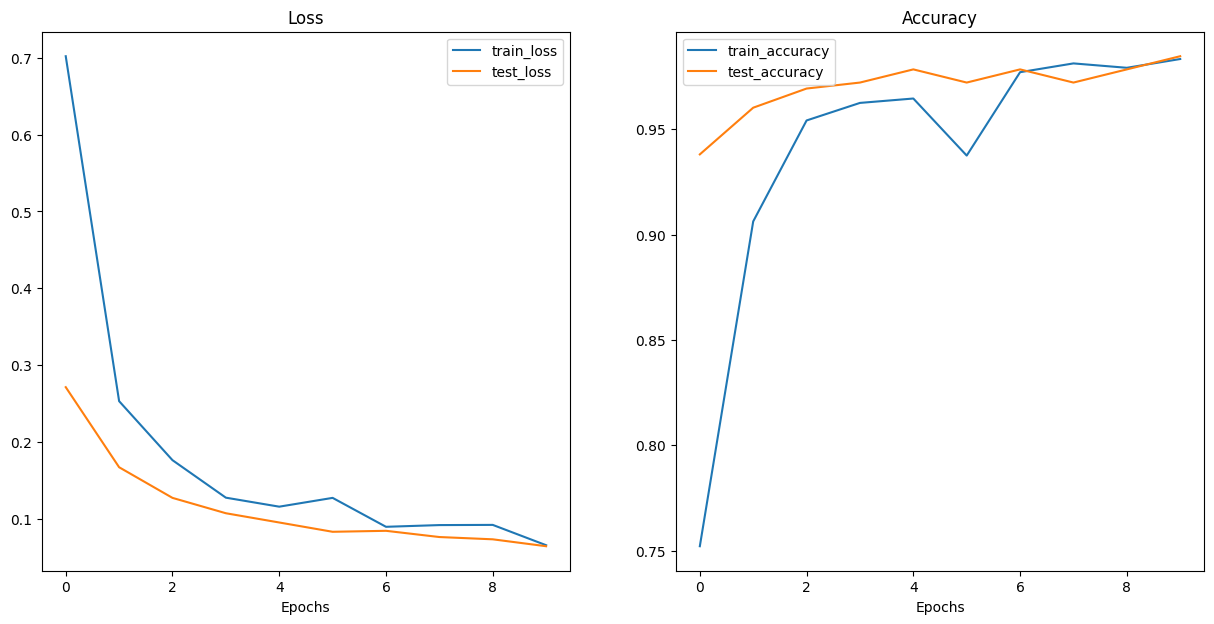

In [46]:
plot_loss_curves(vit_results)

In [ ]:
import pathlib
import torch
from PIL import Image

from typing import List, Dict
from pathlib import Path
# get paths and labels
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
from tqdm.auto import tqdm
test_labels = [path.parent.stem for path in test_data_paths]

def pred_and_store(test_paths: List[pathlib.Path], 
                   model: torch.nn.Module,
                   transform: torchvision.transforms, 
                   class_names: List[str], 
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:
    
    pred_list = []
    
    for path in tqdm(test_paths):
        
        pred_dict = {}
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name
        
        start_time = timer()
        
        img = Image.open(path)

        transformed_image = transform(img).unsqueeze(0).to(device) 
        
        model = model.to(device)
        model.eval()

        with torch.inference_mode():
            pred_logit = model(transformed_image) # perform inference on target sample 
            pred_prob = torch.softmax(pred_logit, dim=1) # turn logits into prediction probabilities
            pred_label = torch.argmax(pred_prob, dim=1) # turn prediction probabilities into prediction label
            pred_class = class_names[pred_label.cpu()] # hardcode prediction class to be on CPU

            pred_dict["pred_prob"] = round(pred_prob.max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class
            
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time-start_time, 4)

        pred_dict["correct"] = class_name == pred_class

        pred_list.append(pred_dict)

    return pred_list




In [56]:
# predicting on cpu
effnetb2_preds_on_cpu = pred_and_store(test_paths=test_data_paths, 
                                       model=EffNetB2,
                                       transform=EffNetB2_transforms,
                                       class_names=class_names,
                                       device="cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

In [57]:
vit_preds_on_cpu = pred_and_store(test_paths=test_data_paths, 
                                  model=vit,
                                  transform=vit_transforms,
                                  class_names=class_names,
                                  device="cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

In [58]:
effnetb2_preds_on_gpu = pred_and_store(test_paths=test_data_paths, 
                                       model=EffNetB2,
                                       transform=EffNetB2_transforms,
                                       class_names=class_names,
                                       device="cuda")

vit_preds_on_gpu = pred_and_store(test_paths=test_data_paths, 
                                  model=vit,
                                  transform=vit_transforms,
                                  class_names=class_names,
                                  device="cuda")

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
import pandas as pd

def get_mean_pred_time(input):
  df = pd.DataFrame(input)
  return df.time_for_pred.mean()

In [ ]:
effnetb2_cpu_pred_time = get_mean_pred_time(effnetb2_preds_on_cpu)
effnetb2_gpu_pred_time = get_mean_pred_time(effnetb2_preds_on_gpu)
vit_cpu_pred_time = get_mean_pred_time(vit_preds_on_cpu)
vit_gpu_pred_time = get_mean_pred_time(vit_preds_on_gpu)

pred_times = {"effnetb2_cpu": effnetb2_cpu_pred_time,
              "vit_cpu": vit_cpu_pred_time,
              "effnetb2_gpu": effnetb2_gpu_pred_time,
              "vit_gpu": vit_gpu_pred_time}

pred_times_df = pd.DataFrame(pred_times, index=[0])
pred_times_df

## Exercise 3. Make predictions across the 20% Food101 test dataset with the ViT feature extractor from exercise 2 and find the "most wrong" predictions
* The predictions will be the ones with the highest prediction probability but with the wrong predicted label.
* Write a sentence or two about why you think the model got these predictions wrong.

In [ ]:
test_pred_list = pred_and_store(test_paths=test_data_paths,
                                model=vit,
                                transform=vit_transforms,
                                class_names=class_names,
                                device=device)

test_pred_list[:3]

In [50]:
import pandas as pd
test_pred_df = pd.DataFrame(test_pred_list)
# Sort DataFrame by correct then by pred_prob 
top_5_most_wrong = test_pred_df.sort_values(by=["correct", "pred_prob"], ascending=[True, False]).head()
top_5_most_wrong

,image_path,class_name,pred_prob,pred_class,correct
96,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,"tensor(0.5065, device='cuda:0')",sushi,False
89,data/pizza_steak_sushi_20_percent/test/sushi/3...,sushi,"tensor(0.4976, device='cuda:0')",pizza,False
28,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,"tensor(0.9990, device='cuda:0')",pizza,True
20,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,"tensor(0.9989, device='cuda:0')",pizza,True
8,data/pizza_steak_sushi_20_percent/test/pizza/4...,pizza,"tensor(0.9989, device='cuda:0')",pizza,True


/tmp/ipykernel_60225/4199008945.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image_path = row[0]
/tmp/ipykernel_60225/4199008945.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  true_label = row[1]
/tmp/ipykernel_60225/4199008945.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred_prob = row[2]
/tmp/ipykernel_60225/4199008945.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future

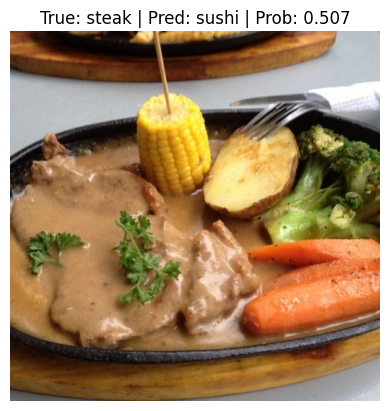

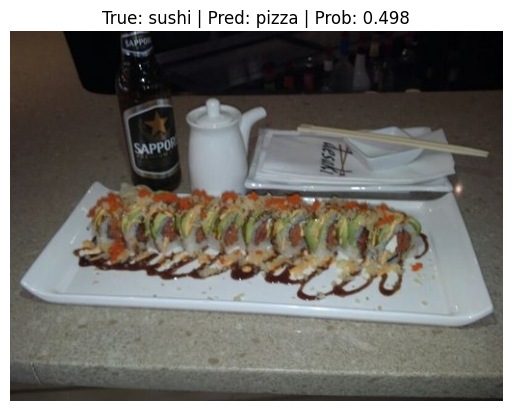

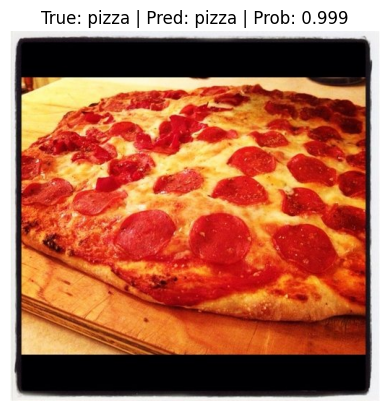

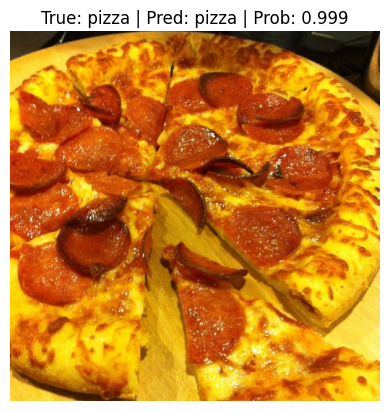

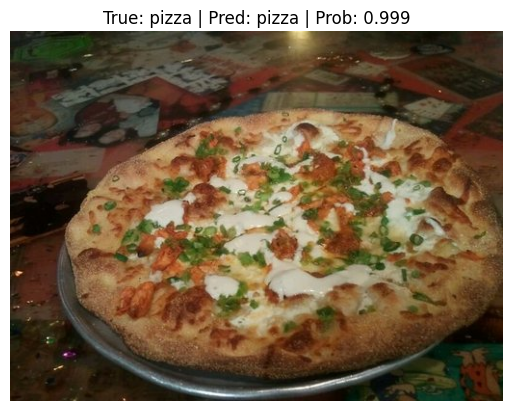

In [51]:
import torchvision
import matplotlib.pyplot as plt
# Plot the top 5 most wrong images
for row in top_5_most_wrong.iterrows():
  row = row[1]
  image_path = row[0]
  true_label = row[1]
  pred_prob = row[2]
  pred_class = row[3]
  # Plot the image and various details
  img = torchvision.io.read_image(str(image_path)) # get image as tensor
  plt.figure()
  plt.imshow(img.permute(1, 2, 0)) # HWC and CHW

  plt.title(f"True: {true_label} | Pred: {pred_class} | Prob: {pred_prob:.3f}")
  plt.axis(False)

这里第一个其实还好解释，牛排被盖住了，但第二个sushi预测成pizza完全没道理。。难道是因为有啤酒的出现吗？

## Exercise 4. Evaluate the ViT feature extractor across the whole Food101 test dataset rather than just the 20% version, how does it perform?
* Does it beat the original Food101 paper's best result of 56.4% accuracy?

In [13]:
# TODO: your code

## Exercise 5. Head to [Paperswithcode.com](https://paperswithcode.com/) and find the current best performing model on the Food101 dataset.
* What model architecture does it use?

In [14]:
# TODO: your answer to the above

## Exercise 6. Write down 1-3 potential failure points of our deployed FoodVision models and what some potential solutions might be.
* For example, what happens if someone was to upload a photo that wasn't of food to our FoodVision Mini model?

In [15]:
# TODO: your answer to the above

## Exercise 7. Pick any dataset from [`torchvision.datasets`](https://pytorch.org/vision/stable/datasets.html) and train a feature extractor model on it using a model from [`torchvision.models`](https://pytorch.org/vision/stable/models.html) (you could use one of the model's we've already created, e.g. EffNetB2 or ViT) for 5 epochs and then deploy your model as a Gradio app to Hugging Face Spaces. 
* You may want to pick smaller dataset/make a smaller split of it so training doesn't take too long.
* I'd love to see your deployed models! So be sure to share them in Discord or on the [course GitHub Discussions page](https://github.com/mrdbourke/pytorch-deep-learning/discussions).

In [16]:
# TODO: your code